In [7]:
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [8]:
# Callback - introduce constraint to check if there's too many people in a place at the same time

def create_num_people(entry_times,exit_times):
    num_people = {i:0 for i in task_ids}
    yy1 = {(i,j):0 for i in task_ids for j in task_ids}
    yy2 = {(i,j):0 for i in task_ids for j in task_ids}

    for i in task_ids: 
        for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])):
            yy1[(i,j)] = int(entry_times[j]>=entry_times[i])

    for i in task_ids: 
        for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])):
            yy2[(i,j)] = int(entry_times[j]>=exit_times[i])

    for j in task_ids:
        num_people[j] = sum([yy1[(i,j)]-yy2[(i,j)] for i in np.array(place_dict[vertices_dict[j]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[j]['place_id']]['task_list']))])
    
    return num_people

In [9]:
def import_instance(file):

    f = open(file, 'r')
    lines = f.readlines()
    lines = [l[0:len(l)-1] for l in lines]
    start_time = int(lines[0].split(" ")[1])
    end_time = int(lines[0].split(" ")[2])
    max_time = end_time-start_time
    #import people
    number_of_people = int(lines[2].split(" ")[1])
    vertices_dict = [{'place_id':0,'budget':0, 'max_nb_changes_transport':0, 'task_list':[]} for i in range(number_of_people)]

    house_ids = list(range(number_of_people))

    for i in house_ids:
        vertices_dict[i]['place_id'] = int(lines[4+7*i].split(" ")[1])
        vertices_dict[i]['budget'] = int(lines[7+i*7].split(" ")[1])
        vertices_dict[i]['max_nb_changes_transport'] = int(lines[8+i*7].split(" ")[1])
    #import places
    current_line = 7*number_of_people+3
    number_of_places = int(lines[current_line].split(" ")[1])

    place_dict = {i:{'lat':0,'lon':0,'max_people':0,'task_list':[]} for i in range(number_of_people+1,number_of_people+number_of_places+1)}

    for i in range(number_of_places):
        j = int(lines[current_line+5*i+1].split(" ")[1])
        place_dict[j]['lat'] = float(lines[current_line+5*i+2].split(" ")[1])
        place_dict[j]['lon']  = float(lines[current_line+5*i+3].split(" ")[1])
        place_dict[j]['max_people'] = int(lines[current_line+5*i+4].split(" ")[1])
    #import_tasks
    current_line = 7*number_of_people+3 + number_of_places*5+1
    number_of_tasks = int(lines[current_line].split(" ")[1])
    task_ids = list(range(number_of_people,number_of_people+number_of_tasks))
    vertices_dict = vertices_dict + [{'task_id':0,'person_id':0,'place_id':0,'cost':0,'service_time':0,'start_time':0,'end_time':0,'is_special':0,'extra_time':0,'penalty':0} for i in range(number_of_tasks)]
    for i in range(number_of_tasks):
        vertices_dict[i+number_of_people]['task_id'] = int(lines[current_line+11*i+1].split(" ")[1])
        vertices_dict[i+number_of_people]['person_id'] = int(lines[current_line+11*i+2].split(" ")[1])
        vertices_dict[i+number_of_people]['place_id'] = int(lines[current_line+11*i+3].split(" ")[1])
        vertices_dict[i+number_of_people]['cost'] = int(lines[current_line+11*i+4].split(" ")[1])
        vertices_dict[i+number_of_people]['service_time'] = int(lines[current_line+11*i+5].split(" ")[1])
        vertices_dict[i+number_of_people]['start_time'] = int(lines[current_line+11*i+6].split(" ")[1])-start_time
        vertices_dict[i+number_of_people]['end_time'] = int(lines[current_line+11*i+7].split(" ")[1])-start_time
        vertices_dict[i+number_of_people]['is_special'] = int(lines[current_line+11*i+8].split(" ")[1])
        vertices_dict[i+number_of_people]['extra_time'] = int(lines[current_line+11*i+9].split(" ")[1])
        vertices_dict[i+number_of_people]['penalty'] = int(lines[current_line+11*i+10].split(" ")[1])
    #associates people and places with tasks to perform
    for i in range(number_of_tasks):
        vertices_dict[vertices_dict[i+number_of_people]['person_id']-1]['task_list'].append(vertices_dict[i+number_of_people]['task_id'])
        place_dict[vertices_dict[i+number_of_people]['place_id']]['task_list'].append(vertices_dict[i+number_of_people]['task_id'])
    #import bike stops
    current_line = 7*number_of_people+3 + number_of_places*5+number_of_tasks*11+7
    number_of_bike_stations = int(lines[current_line].split(" ")[1])

    bike_out_ids = list(range(number_of_people+number_of_tasks,number_of_people+number_of_tasks+number_of_bike_stations))
    bike_in_ids = list(range(number_of_people+number_of_tasks+number_of_bike_stations,number_of_people+number_of_tasks+2*number_of_bike_stations))

    vertices_dict = vertices_dict + [{'place_id':0,'available_bikes':0, 'lat':0, 'lon':0} for i in range(number_of_bike_stations)]
    vertices_dict = vertices_dict + [{'place_id':0,'free_spots':0, 'lat':0, 'lon':0} for i in range(number_of_bike_stations)]
    for i in range(number_of_bike_stations):
        vertices_dict[i+number_of_people+number_of_tasks]['place_id'] = int(lines[current_line+6*i+1].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks+number_of_bike_stations]['place_id'] = int(lines[current_line+6*i+1].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks]['available_bikes'] = int(lines[current_line+6*i+4].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks+number_of_bike_stations]['free_spots'] = int(lines[current_line+6*i+5].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks]['lat'] = float(lines[current_line+6*i+2].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks+number_of_bike_stations]['lat'] = float(lines[current_line+6*i+2].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks]['lon'] = float(lines[current_line+6*i+3].split(" ")[1])
        vertices_dict[i+number_of_people+number_of_tasks+number_of_bike_stations]['lat'] = float(lines[current_line+6*i+2].split(" ")[1])
    current_line = 7*number_of_people+3 + number_of_places*5+number_of_tasks*11+ 7 + number_of_bike_stations*6+1
    number_of_lines = int(lines[current_line].split(" ")[1])
    current_line = current_line + number_of_lines*5 + 1
    number_of_bus_stops = int(lines[current_line].split(" ")[1])
    current_line = current_line + number_of_bus_stops*4+2

    while(lines[current_line] != ''):
        current_line = current_line + 1

    bike_cost_pm = float(lines[current_line+1].split(" ")[1])
    bus_cost_pr = float(lines[current_line+2].split(" ")[1])
    tot_number_of_places = number_of_people + number_of_tasks + 2*number_of_bike_stations

    #import walking data
    walking_times = [[0 for i in range(tot_number_of_places)] for j in range(tot_number_of_places)]
    walking_fitness = [[0 for i in range(tot_number_of_places)] for j in range(tot_number_of_places)]
    biking_times = [[0 for i in range(tot_number_of_places)] for j in range(tot_number_of_places)]
    biking_fitness = [[0 for i in range(tot_number_of_places)] for j in range(tot_number_of_places)]

    current_line = current_line + 5

    for i in range(current_line,len(lines)):
        split_way = lines[i].split(" ")
        for i in range(tot_number_of_places):
            if vertices_dict[i]['place_id'] == int(split_way[0]):
                for j in range(tot_number_of_places):
                    if vertices_dict[j]['place_id'] == int(split_way[1]):
                        if split_way[2] == 'WALKING':
                            walking_times[i][j] = float(split_way[4])
                            walking_times[j][i] = float(split_way[4])
                            walking_fitness[i][j] = float(split_way[5])
                            walking_fitness[j][i] = float(split_way[5])
                        if split_way[2] == 'CYCLING':
                            biking_times[i][j] = float(split_way[4])
                            biking_times[j][i] = float(split_way[4])
                            biking_fitness[i][j] = float(split_way[5])
                            biking_fitness[j][i] = float(split_way[5])

    return [max_time, vertices_dict, house_ids, place_dict, task_ids, bike_out_ids, bike_in_ids, bike_cost_pm, walking_times, walking_fitness, biking_times, biking_fitness, number_of_people, tot_number_of_places]

In [10]:
def model_optimize(r_weight, f_weight, p_weight, mins):

    def cutelim(model, where):
        if where == GRB.Callback.MIPSOL:
        
            # make a list of visit times for places in the solution
            entry_times = model.cbGetSolution(u)
            exit_times = model.cbGetSolution(v)
                                
            num_people = create_num_people(entry_times,exit_times)

            for j in task_ids:
                if num_people[j]>place_dict[vertices_dict[j]['place_id']]['max_people']-1:
                    model.cbLazy(gp.quicksum(y1[i,j]-y2[i,j] for i in np.array(place_dict[vertices_dict[j]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[j]['place_id']]['task_list']))) <= place_dict[vertices_dict[j]['place_id']]['max_people']-1)
                    for i in np.array(place_dict[vertices_dict[j]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[j]['place_id']]['task_list'])):
                        model.cbLazy(u[j]-u[i] <= max_time * y1[i,j])
                        model.cbLazy(u[i]-u[j] <= max_time * (1-y1[i,j]))
                        model.cbLazy(u[j]-v[i] <= max_time * y2[i,j])
                        model.cbLazy(v[i]-u[j] <= max_time * (1-y2[i,j]))
    
    # Setting up the environment
    env = gp.Env(empty=True)
    env.start()

    #setting parameters of the solver
    env.setParam("OutputFlag", 0)

    # Initialization of a new model in the defined environment
    model = gp.Model("Planning and multimodal transportation.mps", env=env)
    model.params.lazyConstraints=1
    
    w = model.addVars(number_of_people, tot_number_of_places, tot_number_of_places, vtype = GRB.BINARY, name = 'W') #does the person n walk from i to j
    c = model.addVars(number_of_people, tot_number_of_places, tot_number_of_places, vtype = GRB.BINARY, name = 'C') #does the person n bike from i to j

    z = model.addVars(number_of_people,tot_number_of_places, vtype = GRB.BINARY, name = 'Z') # does the person n go to place i

    s = model.addVars(task_ids, vtype=GRB.BINARY, name='S') # is the task t done as special

    u = model.addVars(task_ids+house_ids, vtype = GRB.CONTINUOUS, lb=0, ub=max_time, name = 'U') #time the person that has to do it enters the place to do task t
    v = model.addVars(task_ids+house_ids, vtype = GRB.CONTINUOUS, lb=0, ub=max_time, name = 'V') #time the person that has to do it exits the place to do task t

    t = model.addVars(number_of_people, bike_in_ids+bike_out_ids, vtype = GRB.CONTINUOUS, lb=0, ub=max_time, name = 'T') #time the person n arrives at the bike place

    y1 = model.addVars(task_ids, task_ids, vtype = GRB.BINARY, name = 'Y1') #is task i started before task j
    y2 = model.addVars(task_ids, task_ids, vtype = GRB.BINARY, name = 'Y2') #does task i end before task j is started

    # does the person have to do the task matrix
    task_association_list = [[vertices_dict[i]['person_id']-1,i] for i in task_ids ]
    # the person has to go to their house e non va nelle altre
    model.addConstrs(z[n,i]==int(n==i) for n in range(number_of_people) for i in house_ids)

    # per quanto riguarda le case entro ed esco una sola volta (se la casa è la mia) e sempre a piedi perchè posso andarci e tornarci solo camminando
    model.addConstrs(gp.quicksum(w[n,i,j] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in house_ids)
    model.addConstrs(gp.quicksum(w[n,j,i] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in house_ids)

    # non vado in bici nelle case
    model.addConstrs(gp.quicksum(c[n,i,j] for j in range(tot_number_of_places))==0 for n in range(number_of_people) for i in house_ids)
    model.addConstrs(gp.quicksum(c[n,j,i] for j in range(tot_number_of_places))==0 for n in range(number_of_people) for i in house_ids)

    # per le task posso andarci solo se la task è mia, e nel caso ci vado una volta sola
    model.addConstrs(z[n,i] <= int([n,i] in task_association_list) for n in range(number_of_people) for i in task_ids)

    # se vado in una task ci vado una volta sola 
    model.addConstrs(gp.quicksum(w[n,i,j]+c[n,i,j] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in task_ids)
    model.addConstrs(gp.quicksum(w[n,j,i]+c[n,j,i] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in task_ids)

    # se vado in un posto bici in o out ci vado una volta sola
    model.addConstrs(gp.quicksum(w[n,j,i] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in bike_out_ids) #entro a piedi nei bike_out
    model.addConstrs(gp.quicksum(c[n,i,j] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in bike_out_ids) #esco in bici dai bike_out
    model.addConstrs(gp.quicksum(c[n,j,i] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in bike_in_ids) #entro in bici nei bike_in
    model.addConstrs(gp.quicksum(w[n,i,j] for j in range(tot_number_of_places))==z[n,i] for n in range(number_of_people) for i in bike_in_ids) #esco a piedi dai bike_in

    # non posso andare a piedi in un bike_in e in bici in un bike_out
    model.addConstrs(c[n,j,i]==0 for j in range(tot_number_of_places) for n in range(number_of_people) for i in bike_out_ids) #entro a piedi nei bike_out
    model.addConstrs(w[n,i,j]==0 for j in range(tot_number_of_places) for n in range(number_of_people) for i in bike_out_ids) #esco in bici dai bike_out
    model.addConstrs(w[n,j,i]==0 for j in range(tot_number_of_places) for n in range(number_of_people) for i in bike_in_ids) #entro in bici nei bike_in
    model.addConstrs(c[n,i,j]==0 for j in range(tot_number_of_places) for n in range(number_of_people) for i in bike_in_ids) #esco a piedi dai bike_in

    # se entro a piedi esco a piedi, se entro in bici, esco in bici
    model.addConstrs(gp.quicksum(w[n,j,i]for j in range(tot_number_of_places))==gp.quicksum(w[n,i,j]for j in range(tot_number_of_places)) for n in range(number_of_people) for i in task_ids)
    model.addConstrs(gp.quicksum(c[n,j,i]for j in range(tot_number_of_places))==gp.quicksum(c[n,i,j]for j in range(tot_number_of_places)) for n in range(number_of_people) for i in task_ids)

    #walking or cycling from a place to itself doesn't make sense
    model.addConstrs(w[n,i,i]==0 for n in range(number_of_people) for i in range(tot_number_of_places))
    model.addConstrs(c[n,i,i]==0 for n in range(number_of_people) for i in range(tot_number_of_places))
    model.addConstrs(s[t]<=vertices_dict[t]['is_special'] for t in task_ids) #a task can't be done as special if it isn't special
    model.addConstrs(s[t]<=z[vertices_dict[t]['person_id']-1,t] for t in task_ids) #a task can't be done as special if we decide not to do it

    model.addConstrs(u[i]>=v[i] for i in house_ids)

    #the enter and exit time are both 0 if the place is the task is not done
    model.addConstrs(u[t]<=max_time*z[vertices_dict[t]['person_id']-1,t] for t in task_ids)
    model.addConstrs(v[t]<=max_time*z[vertices_dict[t]['person_id']-1,t] for t in task_ids)

    #the task has to be done in the time window
    model.addConstrs(u[t] >= vertices_dict[t]['start_time']*z[vertices_dict[t]['person_id']-1,t] - max_time*s[t] for t in task_ids)
    model.addConstrs(u[t] <= vertices_dict[t]['end_time']*z[vertices_dict[t]['person_id']-1,t] + max_time*(1-z[vertices_dict[t]['person_id']-1,t]+s[t]) for t in task_ids)
    model.addConstrs(v[t] >= u[t] + vertices_dict[t]['service_time']*z[vertices_dict[t]['person_id']-1,t] + vertices_dict[t]['extra_time']*s[t] for t in task_ids)

    #regulates the evolution of time for houses and task places
    model.addConstrs(v[i]-u[j] + walking_times[i][j] <= max_time*(1-w[n,i,j]) for n in range(number_of_people) for i in list(np.array(vertices_dict[n]['task_list'])+np.array([number_of_people-1]*len(vertices_dict[n]['task_list'])))+[n] for j in list(np.array(vertices_dict[n]['task_list'])+np.array([number_of_people-1]*len(vertices_dict[n]['task_list'])))+[n])
    model.addConstrs(v[i]-u[j] + biking_times[i][j] <= max_time*(1-c[n,i,j]) for n in range(number_of_people) for i in list(np.array(vertices_dict[n]['task_list'])+np.array([number_of_people-1]*len(vertices_dict[n]['task_list']))) for j in list(np.array(vertices_dict[n]['task_list'])+np.array([number_of_people-1]*len(vertices_dict[n]['task_list']))))
    # time regulation for bike places

    # the time is zero if the place is not visited
    model.addConstrs(t[n,i]<=max_time*z[n,i] for n in range(number_of_people) for i in bike_in_ids+bike_out_ids)

    #viaggio da posti a bici
    model.addConstrs(v[i] - t[n,j] + walking_times[i][j] <= max_time*(1-w[n,i,j]) for i in house_ids+task_ids for j in bike_out_ids for n in range(number_of_people))
    model.addConstrs(v[i] - t[n,j] + biking_times[i][j] <= max_time*(1-c[n,i,j]) for i in task_ids for j in bike_in_ids for n in range(number_of_people))

    #viaggio da bici a posti
    model.addConstrs(t[n,i] - u[j] + walking_times[i][j] <= max_time*(1-w[n,i,j]) for j in house_ids+task_ids for i in bike_in_ids for n in range(number_of_people))
    model.addConstrs(t[n,i] - u[j] + biking_times[i][j] <= max_time*(1-c[n,i,j]) for j in task_ids for i in bike_out_ids for n in range(number_of_people))

    #viaggio da bici a bici
    model.addConstrs(t[n,i] - t[n,j] + walking_times[i][j] <= max_time*(1-w[n,i,j]) for j in bike_out_ids for i in bike_in_ids for n in range(number_of_people))
    model.addConstrs(t[n,i] - t[n,j] + biking_times[i][j] <= max_time*(1-c[n,i,j]) for j in bike_in_ids for i in bike_out_ids for n in range(number_of_people))
    #number of people in a place at the same time
    model.addConstrs(y1[j,j] == 0 for j in task_ids)
    model.addConstrs(y2[j,j] == 0 for j in task_ids)

    # if tasks i and j are not done in the same place i don't care
    model.addConstrs(y1[i,j] == 0 for i in task_ids for j in task_ids  if j not in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    model.addConstrs(y2[i,j] == 0 for i in task_ids for j in task_ids if j not in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))

    c1 = model.addConstrs(u[j]-u[i] <= max_time * y1[i,j] for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    c1.Lazy = 2
    c2 = model.addConstrs(u[i]-u[j] <= max_time * (1-y1[i,j]) for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    c2.Lazy = 2

    c3 = model.addConstrs(u[j]-v[i] <= max_time * y2[i,j] for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    c3.Lazy = 2
    c4 = model.addConstrs(v[i]-u[j] <= max_time * (1-y2[i,j]) for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    c4.Lazy = 2

    c5 = model.addConstrs(gp.quicksum(y1[i,j]-y2[i,j] for i in np.array(place_dict[vertices_dict[j]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[j]['place_id']]['task_list']))) <= place_dict[vertices_dict[j]['place_id']]['max_people']-1 for j in task_ids)
    c5.Lazy = 2

    # if i ends before j then it has to start before j
    model.addConstrs(y2[i,j]<=y1[i,j] for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])))
    model.addConstrs(y1[i,j]+y1[j,i]==1 for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])) if i>j)
    model.addConstrs(y2[i,j]+y2[j,i]<=1 for i in task_ids for j in np.array(place_dict[vertices_dict[i]['place_id']]['task_list'])+np.array([number_of_people-1]*len(place_dict[vertices_dict[i]['place_id']]['task_list'])) if i>j)
    # cambi di mezzo
    model.addConstrs(gp.quicksum(z[n,i] for i in bike_in_ids+bike_out_ids) <= vertices_dict[n]['max_nb_changes_transport'] for n in range(number_of_people))
    # budget
    model.addConstrs(gp.quicksum(z[n,t]*vertices_dict[t]['cost'] for t in task_ids) <= vertices_dict[n]['budget'] for n in range(number_of_people))
    model.setObjective(r_weight*gp.quicksum(u[t]-v[t] for t in house_ids) - f_weight*gp.quicksum(walking_fitness[i][j]*w[n,i,j] for n in range(number_of_people) for i in range(tot_number_of_places) for j in range(tot_number_of_places)) + p_weight*gp.quicksum(vertices_dict[t]['penalty']*(1-z[vertices_dict[t]['person_id']-1,t]) for t in task_ids), GRB.MINIMIZE)
    model.update()
    model.setParam('TimeLimit',mins*60)
    model.optimize(cutelim)

    return [model.objVal,model.MIPGap]

In [11]:
r_weight, f_weight, p_weight = [1,1,1]

In [14]:
instances = ['instance_demo1_N10.txt','instance_demo2_N11.txt','instance_demo3_N12.txt']
times = [5,10,15,20,25,30]

objfuns = {(i,j):0 for i in instances for j in times}
mipgaps = {(i,j):0 for i in instances for j in times}

for inst in instances:
    max_time, vertices_dict, house_ids, place_dict, task_ids, bike_out_ids, bike_in_ids, bike_cost_pm, walking_times, walking_fitness, biking_times, biking_fitness, number_of_people, tot_number_of_places = import_instance(inst)
    for t in times:
        objfuns[(inst,t)], mipgaps[(inst,t)] = model_optimize(r_weight, f_weight, p_weight, t)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24

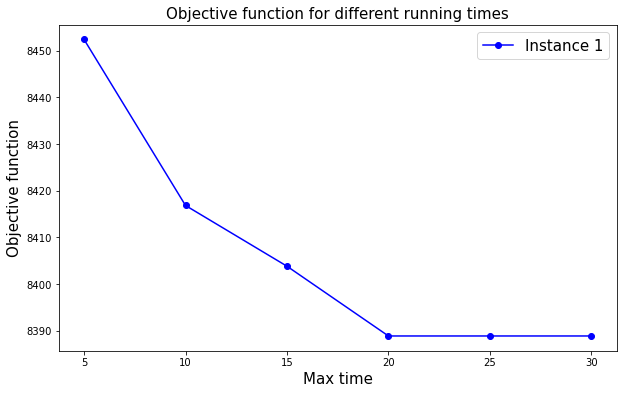

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(times, [objfuns['instance_demo1_N10.txt',x] for x in times],"-o",color='b',label="Instance 1")
plt.title("Objective function for different running times", fontsize=15)
plt.xlabel("Max time", fontsize=15)
plt.ylabel("Objective function", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Objective function for different running times instance 1.png')
plt.show()

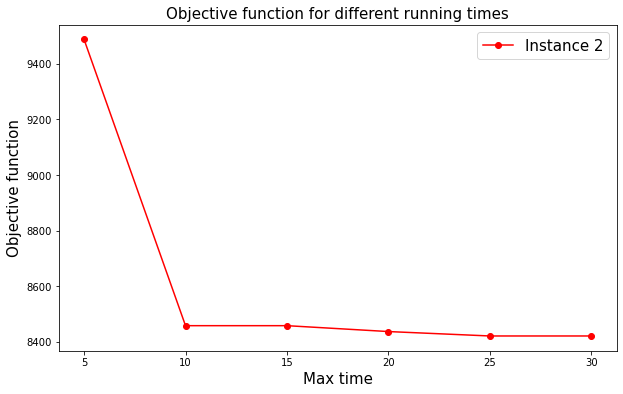

In [20]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, [objfuns['instance_demo2_N11.txt',x] for x in times],"-o",color='r',label="Instance 2")
plt.title("Objective function for different running times", fontsize=15)
plt.xlabel("Max time", fontsize=15)
plt.ylabel("Objective function", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Objective function for different running times instance 2.png')
plt.show()

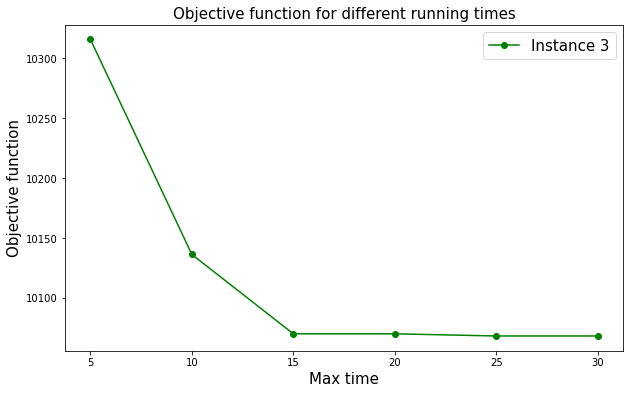

In [21]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, [objfuns['instance_demo3_N12.txt',x] for x in times],"-o",color='g',label="Instance 3")
plt.title("Objective function for different running times", fontsize=15)
plt.xlabel("Max time", fontsize=15)
plt.ylabel("Objective function", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Objective function for different running times instance 3.png')
plt.show()

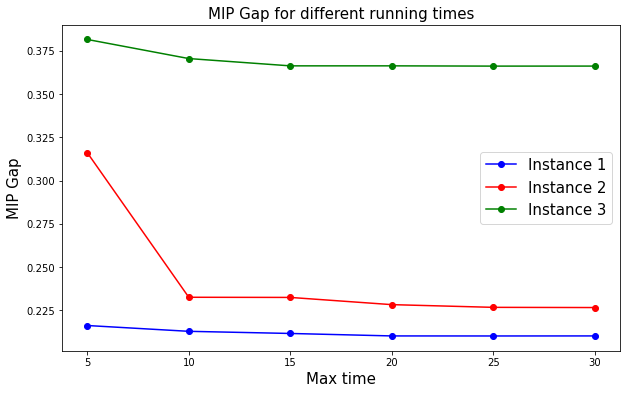

In [22]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, [mipgaps['instance_demo1_N10.txt',x] for x in times],"-o",color='b',label="Instance 1")
plt.plot(times, [mipgaps['instance_demo2_N11.txt',x] for x in times],"-o",color='r',label="Instance 2")
plt.plot(times, [mipgaps['instance_demo3_N12.txt',x] for x in times],"-o",color='g',label="Instance 3")
plt.title("MIP Gap for different running times", fontsize=15)
plt.xlabel("Max time", fontsize=15)
plt.ylabel("MIP Gap", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('MIP Gap for different running times.png')
plt.show()